# Polyp Detection on Colonoscopy Images using RetinaNet

## Load the Dataset

In [1]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import skimage
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.color import *
from sklearn.model_selection import train_test_split
import cv2

import pandas as pd

In [2]:
dir_cvc = './CVC-ClinicDB-crop'
dir_etis = './ETIS-LaribPolypDB'
dir_kvasir = './Kvasir-SEG'

images_cvc = sorted(glob(os.path.join(dir_cvc, "Original/*")))
masks_cvc = sorted(glob(os.path.join(dir_cvc, "Ground Truth/*")))
images_etis = sorted(glob(os.path.join(dir_etis, "ETIS-LaribPolypDB/*")))
masks_etis= sorted(glob(os.path.join(dir_etis, "Ground Truth/*")))
images_kvasir = sorted(glob(os.path.join(dir_kvasir, "images/*")))
masks_kvasir= sorted(glob(os.path.join(dir_kvasir, "masks/*")))

In [3]:
print('Total data from CVC ', len(images_cvc))
print('Total data from ETIS ', len(images_etis))
print('Total data from KVASIR ', len(images_kvasir))

Total data from CVC  612
Total data from ETIS  196
Total data from KVASIR  1000


In [4]:
images_total_path = [*images_cvc, *images_etis, *images_kvasir]
len(images_total_path)

1808

In [5]:
masks_total_path = [*masks_cvc, *masks_etis, *masks_kvasir]
len(images_total_path)

1808

In [6]:
masks_total_path[1200:1205]

['./Kvasir-SEG\\masks\\cju35oyvd3y850988km12hdz1.jpg',
 './Kvasir-SEG\\masks\\cju3tp94kfstl08181awh6z49.jpg',
 './Kvasir-SEG\\masks\\cju3tsh4lfsok0987w6x3a0v1.jpg',
 './Kvasir-SEG\\masks\\cju3ttznuftyf09875t11850w.jpg',
 './Kvasir-SEG\\masks\\cju3tvffffx5f0818t5ov22al.jpg']

In [7]:
images_total_path[610:617]

['./CVC-ClinicDB-crop\\Original\\98.png',
 './CVC-ClinicDB-crop\\Original\\99.png',
 './ETIS-LaribPolypDB\\ETIS-LaribPolypDB\\1.tif',
 './ETIS-LaribPolypDB\\ETIS-LaribPolypDB\\10.tif',
 './ETIS-LaribPolypDB\\ETIS-LaribPolypDB\\100.tif',
 './ETIS-LaribPolypDB\\ETIS-LaribPolypDB\\101.tif',
 './ETIS-LaribPolypDB\\ETIS-LaribPolypDB\\102.tif']

In [8]:
masks_total_path[610:617]

['./CVC-ClinicDB-crop\\Ground Truth\\98.png',
 './CVC-ClinicDB-crop\\Ground Truth\\99.png',
 './ETIS-LaribPolypDB\\Ground Truth\\p1.tif',
 './ETIS-LaribPolypDB\\Ground Truth\\p10.tif',
 './ETIS-LaribPolypDB\\Ground Truth\\p100.tif',
 './ETIS-LaribPolypDB\\Ground Truth\\p101.tif',
 './ETIS-LaribPolypDB\\Ground Truth\\p102.tif']

In [9]:
def create_data_list(img_path, mask_path, split=0.1):
    total_size = len(img_path)
    split_number = int(split*total_size)
    
    train_x, valid_x = train_test_split(img_path, test_size=split_number, random_state=31)
    train_y, valid_y = train_test_split(mask_path, test_size=split_number, random_state=31)
    
    train_x, test_x = train_test_split(train_x, test_size=split_number, random_state=31)
    train_y, test_y = train_test_split(train_y, test_size=split_number, random_state=31)
    
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [10]:
def read_image(image_path, image_size): 
    x = imread(image_path)
    x = resize(x, (image_size, image_size))
    x = x[:, :,0:3]
    return x

def read_mask(mask_path, image_size):
    x = imread(mask_path, as_gray=True)
    x = resize(x, (image_size, image_size))
    x = np.expand_dims(x, axis=-1) 
    
    return x

In [11]:
def prepare_data(image_paths_list, mask_paths_list, image_size=512):
    images = np.ndarray((len(image_paths_list), image_size, image_size, 3)).astype('float32')
    labels = np.ndarray((len(image_paths_list), image_size, image_size, 1)).astype('float32')
    for i in range(len(image_paths_list)):
        images[i]=read_image(image_paths_list[i], image_size=image_size)
        labels[i]=read_mask(mask_paths_list[i], image_size=image_size)
    return images, labels

In [12]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = create_data_list(images_total_path, masks_total_path)
print(len(train_x))
print(len(valid_x))
print(len(test_x))

1448
180
180


In [13]:
(train_images, train_labels) = prepare_data(train_x, train_y)
print("Training Images Shape :", train_images.shape)
print("Training Labels Shape :", train_labels.shape)

Training Images Shape : (1448, 512, 512, 3)
Training Labels Shape : (1448, 512, 512, 1)


In [14]:
(valid_images, valid_labels) = prepare_data(valid_x, valid_y)
print("Valid Images Shape :", valid_images.shape)
print("Valid Labels Shape :", valid_labels.shape)

Valid Images Shape : (180, 512, 512, 3)
Valid Labels Shape : (180, 512, 512, 1)


In [15]:
(test_images, test_labels) = prepare_data(test_x, test_y)
print("Test Images Shape :", test_images.shape)
print("Test Labels Shape :", test_labels.shape)

Test Images Shape : (180, 512, 512, 3)
Test Labels Shape : (180, 512, 512, 1)


In [16]:
train_labels[train_labels>=0.95]=1 ; train_labels[train_labels<0.95]=0
valid_labels[valid_labels>=0.95]=1 ; valid_labels[valid_labels<0.95]=0
test_labels[test_labels>=0.95]=1 ;test_labels[test_labels<0.95]=0

## Create Bounding Box from Mask

In [17]:
from skimage.measure import label, regionprops, find_contours

In [18]:
""" Convert a mask to border image """
def mask_to_border(mask):
    h, w = mask.shape
    border = np.zeros((h, w))
    contours = find_contours(mask, 0.5)
    for contour in contours:
        for c in contour:
            x = int(c[0])
            y = int(c[1])
            border[x][y] = 1
    return border
""" Mask to bounding boxes """
def mask_to_bbox(mask,dataframe,n):
    #for i in range(180):
    bboxes = []
    border = mask_to_border(mask[:,:,0])
    lbl = label(border)
    props = regionprops(lbl)
    for prop in props:
        x1 = prop.bbox[1]
        y1 = prop.bbox[0]
        x2 = prop.bbox[3]
        y2 = prop.bbox[2]
        new_row = {'img_path':i,'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2, 'class_name':'polyp'}
        dataframe = dataframe.append(new_row, ignore_index=True)
        # bboxes.append([y1, x1, y2, x2])
    #bboxes=np.array(bboxes)
    return dataframe

In [19]:
df_train_label = pd.DataFrame(columns=['img_path', 'x1', 'y1', 'x2', 'y2', 'class_name'])
df_valid_label = pd.DataFrame(columns=['img_path', 'x1', 'y1', 'x2', 'y2', 'class_name' ])  
df_test_label = pd.DataFrame(columns=['img_path', 'x1', 'y1', 'x2', 'y2', 'class_name' ])  

In [20]:
df_test_label.head()

,img_path,x1,y1,x2,y2,class_name


In [21]:
for i in range(len(train_x)):
    df_train_label = mask_to_bbox(train_labels[i],df_train_label,i)  
for i in range(len(valid_x)):
    df_valid_label = mask_to_bbox(valid_labels[i],df_valid_label,i)    
for i in range(len(test_x)):
    df_test_label = mask_to_bbox(test_labels[i],df_test_label,i)

In [22]:
df_test_label.head()

,img_path,x1,y1,x2,y2,class_name
0,0,118,89,308,267,polyp
1,1,97,307,290,463,polyp
2,2,22,105,380,512,polyp
3,3,190,240,386,426,polyp
4,4,283,210,357,277,polyp


In [23]:
df_valid_label.head()

,img_path,x1,y1,x2,y2,class_name
0,0,24,303,401,498,polyp
1,1,220,202,365,379,polyp
2,2,265,185,506,512,polyp
3,3,0,46,512,512,polyp
4,3,350,340,512,512,polyp


In [24]:
df_train_label.head()

,img_path,x1,y1,x2,y2,class_name
0,0,167,110,470,512,polyp
1,1,82,82,289,384,polyp
2,2,182,33,400,277,polyp
3,3,190,122,473,470,polyp
4,4,159,149,440,471,polyp


In [25]:
df_test_label.shape

(202, 6)

In [26]:
df_valid_label.shape

(198, 6)

In [27]:
df_train_label.shape

(1678, 6)

## Visualize the Data

In [28]:
def visualize_overlay(img,mask,alpha,box):
    masked_img=img.astype(np.float64).copy()
    for c in range(3):
        masked_img[:,:,c]=np.where(mask[:,:,0]>=0.8,masked_img[:,:,c]*(1-alpha)+alpha*1,masked_img[:,:,c])
    f, ax = plt.subplots(1,3, figsize=(21,7)) 
    for i in range(len(box)):
        cv2.rectangle(masked_img, (box[i][0], box[i][1]), (box[i][2], box[i][3]), color=(0, 1, 0), thickness=2)
        cv2.putText(masked_img, str(box[i][4]), (box[i][0], box[i][1]-5), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,0),thickness=2)
    ax[0].set_title("Original Image")
    ax[0].imshow(img, cmap="gray")
    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Ground Truth")
    ax[2].imshow(masked_img)
    ax[2].set_title("Overlay + bbox")

In [29]:
def search_bbox(index,df) :
    bbox=df[df['img_path'] == index]
    bbox=bbox.iloc[:, 1:6].to_numpy()
    return bbox

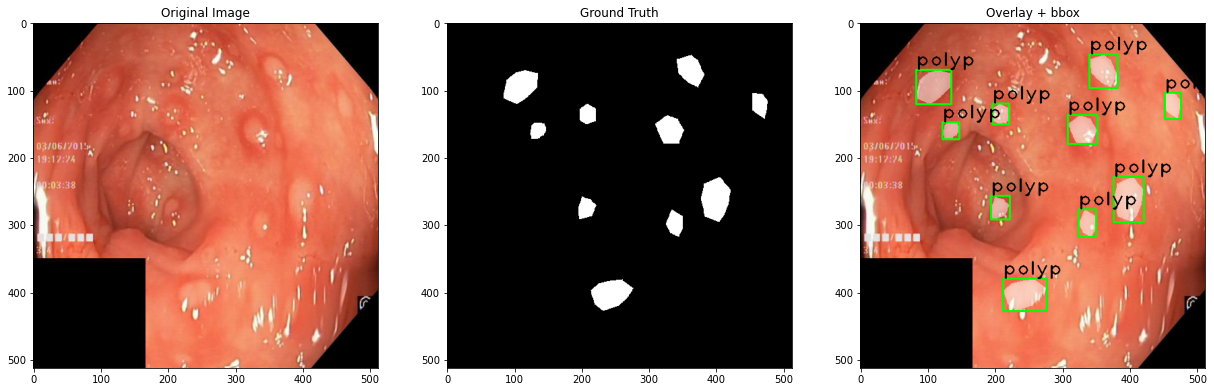

In [30]:
index = 1377
box = search_bbox(index,df_train_label)
visualize_overlay(train_images[index],train_labels[index],0.5, box)

In [31]:
print(box)

[[340 46 382 96 'polyp']
 [83 69 135 120 'polyp']
 [452 103 476 142 'polyp']
 [196 119 221 150 'polyp']
 [308 136 352 179 'polyp']
 [122 147 147 172 'polyp']
 [376 228 421 295 'polyp']
 [194 256 222 291 'polyp']
 [324 276 350 317 'polyp']
 [212 379 277 427 'polyp']]


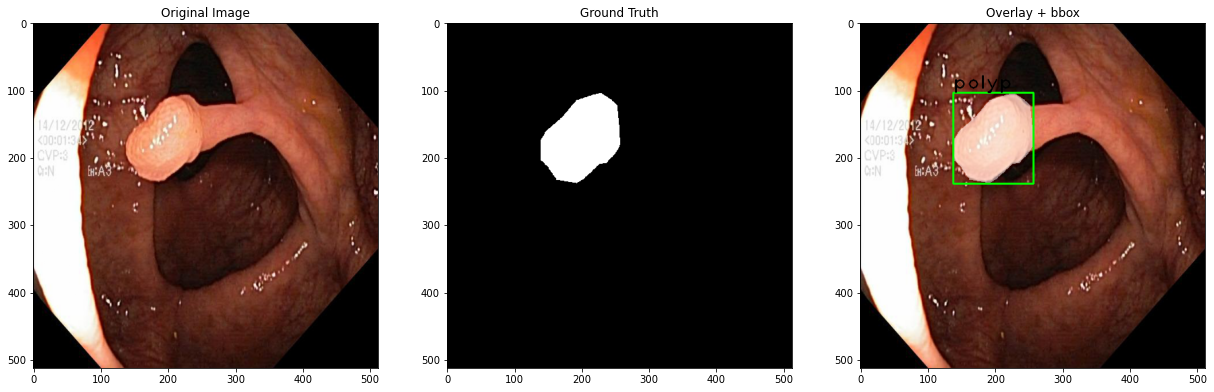

In [32]:
index = 1100
box = search_bbox(index,df_train_label)
visualize_overlay(train_images[index],train_labels[index],0.5, box)

In [33]:
print(box)

[[138 103 257 238 'polyp']]


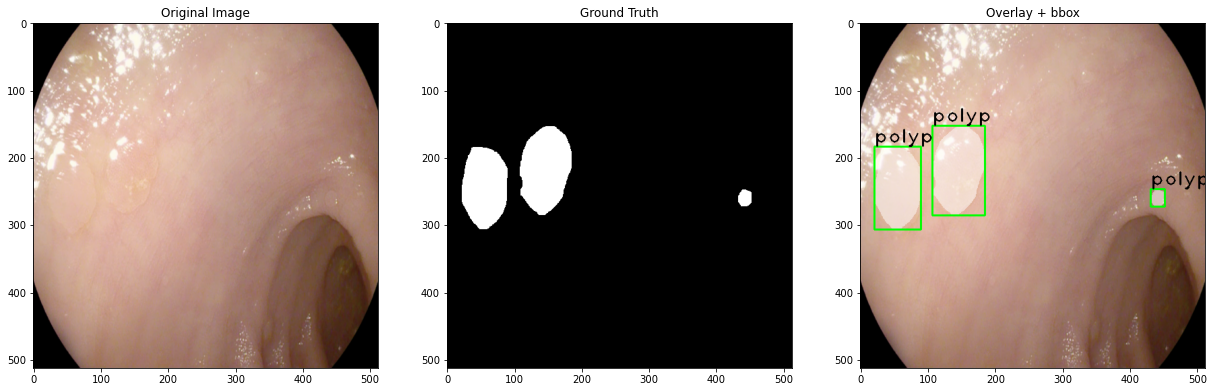

In [34]:
index = 7
box = search_bbox(index,df_test_label)
visualize_overlay(test_images[index],test_labels[index],0.5, box)

In [35]:
print(box)

[[107 152 185 285 'polyp']
 [21 183 90 306 'polyp']
 [431 246 452 272 'polyp']]


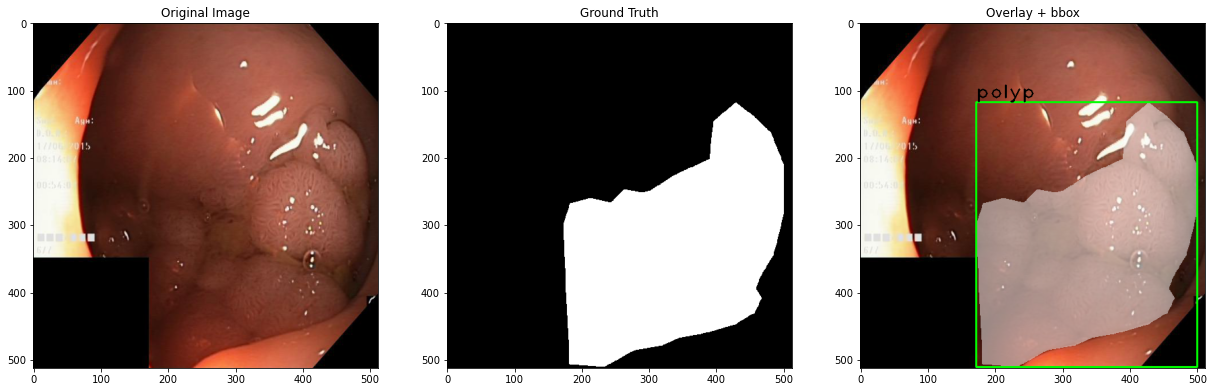

In [36]:
index = 40
box = search_bbox(index,df_valid_label)
visualize_overlay(valid_images[index],valid_labels[index],0.5, box)

In [37]:
print(box)

[[172 117 500 510 'polyp']]


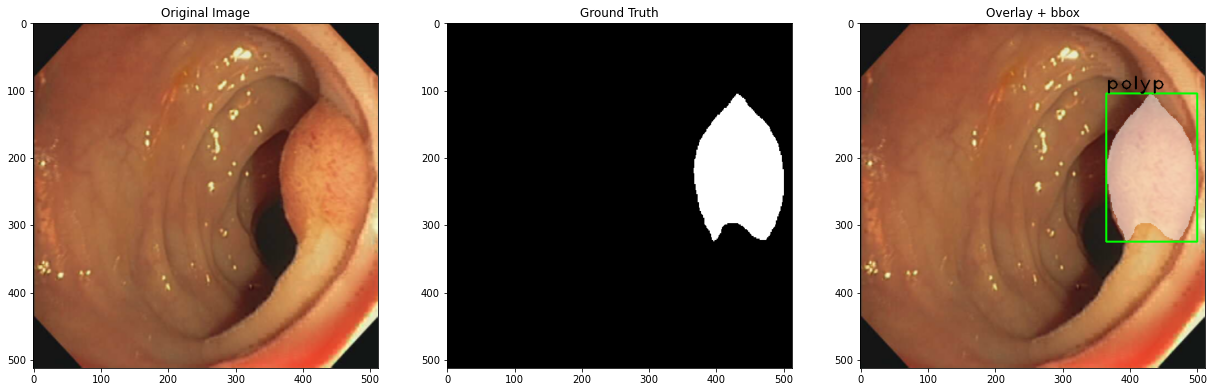

In [38]:
index = 50
box = search_bbox(index,df_test_label)
visualize_overlay(test_images[index],test_labels[index],0.5, box)

In [39]:
print(box)

[[365 104 500 324 'polyp']]


## Save image and DataFrame

In [40]:
from PIL import Image
for i in range(len(train_images)):
    rescaled = (train_images[i]*255).astype(np.uint8)
    Image.fromarray(rescaled,'RGB').save("./dataset/train/"+ str(i)+".png")
for i in range(len(valid_images)):
    rescaled = (valid_images[i]*255).astype(np.uint8)
    Image.fromarray(rescaled,'RGB').save("./dataset/validation/"+ str(i)+".png")  
for i in range(len(test_images)):
    rescaled = (test_images[i]*255).astype(np.uint8)
    Image.fromarray(rescaled,'RGB').save("./dataset/test/"+ str(i)+".png")   

In [41]:
df_train_label['img_path'] = './train/' + df_train_label['img_path'].astype(str) + ".png"
df_valid_label['img_path'] = './validation/' + df_valid_label['img_path'].astype(str) + ".png"
df_test_label['img_path'] = './test/' + df_test_label['img_path'].astype(str) + ".png"

In [42]:
df_train_label.head()

,img_path,x1,y1,x2,y2,class_name
0,./train/0.png,167,110,470,512,polyp
1,./train/1.png,82,82,289,384,polyp
2,./train/2.png,182,33,400,277,polyp
3,./train/3.png,190,122,473,470,polyp
4,./train/4.png,159,149,440,471,polyp


In [43]:
df_valid_label.head()

,img_path,x1,y1,x2,y2,class_name
0,./validation/0.png,24,303,401,498,polyp
1,./validation/1.png,220,202,365,379,polyp
2,./validation/2.png,265,185,506,512,polyp
3,./validation/3.png,0,46,512,512,polyp
4,./validation/3.png,350,340,512,512,polyp


In [44]:
df_test_label.head()

,img_path,x1,y1,x2,y2,class_name
0,./test/0.png,118,89,308,267,polyp
1,./test/1.png,97,307,290,463,polyp
2,./test/2.png,22,105,380,512,polyp
3,./test/3.png,190,240,386,426,polyp
4,./test/4.png,283,210,357,277,polyp


In [45]:
df_train_label.to_csv('./dataset/train.csv', index=False, header=None)
df_valid_label.to_csv('./dataset/validation.csv', index=False, header=None)
df_test_label.to_csv('./dataset/test.csv', index=False, header=None)

In [46]:
class_name = {'class': ['polyp'],'id': [0]}

In [47]:
df_class = pd.DataFrame(class_name)
df_class.to_csv('./dataset/class.csv', index=False, header=None)